# FaceOff - SARSA agent vs. a dummy agent

How well will my SARSA agents (Exact and NN) do against a dummy agent (an agent that randomly selects a free square)

In [26]:
from BaseAgent import BaseAgent
from BaseEnvironment import BaseEnvironment
from RLGlue import RLGlue
from Softmax import softmax
from SimpleNN import SimpleKerasNN

import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import pickle

In [27]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [5]:
class TicTacToeEvnironment(BaseEnvironment):
    def env_init(self, env_info={}):
        pass
    
    def env_start(self):
        self.terminal = False
        self.board = np.zeros((3, 3))
        self.reward_obs_term = (0, self.board, False)
        return self.board.copy().reshape(9), self.get_mask()
    
    def env_step(self, agent_num, index):
        if self.terminal:
            print("Environment in terminal state, please restart.")
        
        row, col = self.transform_index(index)
        self.board[row, col] = agent_num
        
        if self.check_won(agent_num):
            reward = 10
            self.terminal = True
        elif self.check_tie():
            reward = 0
            self.terminal = True
        else:
            reward = -1
            
        self.reward_obs_term_mask = (reward, self.board.copy().reshape(9), self.terminal, self.get_mask())
        return self.reward_obs_term_mask
    
    def check_tie(self):
        return (self.board == 0).sum() == 0
    
    def check_won(self, agent_num):
        for row in self.board:
            if np.array_equal(row, agent_num * np.ones((3,))):
                return True
        for col in self.board.T:
            if np.array_equal(col, agent_num * np.ones((3,))):
                return True
        diag = np.diag(self.board)
        if np.array_equal(diag, agent_num * np.ones((3,))):
            return True
        diag = np.diag(np.fliplr(self.board))
        if np.array_equal(diag, agent_num * np.ones((3,))):
            return True
        return False
    
    def env_cleanup(self):
        pass
    
    def env_message(self, message):
        if message == 0:  # return available indices mask
            return self.get_mask()
            
    def get_mask(self):
        rows, cols = np.where(self.board == 0)
        indices = rows * 3 + cols
        mask = np.zeros((9,))
        mask[indices] = 1
        return mask.astype(int)
    
    def transform_index(self, index):
        return index // 3, index % 3

In [30]:
class DummyAgent(BaseAgent): 
    def agent_init(self, agent_init_info):
        self.num_actions = agent_init_info["num_actions"]
        self.rand_generator = np.random.RandomState(agent_init_info["seed"])
        
        self.last_state = None
        self.last_action = None

    def policy(self, state, mask):
        probs = mask / mask.sum()
        action = self.rand_generator.choice(self.num_actions, p=probs.squeeze())
        return action

    def agent_start(self, state, mask):
        return self.policy(state, mask)

    def agent_step(self, reward, state, mask):
        return self.policy(state, mask)
    
    def agent_end(self, reward):
        pass
        
    def agent_message(self, message):
        pass

## NN Agent

In [6]:
class TicTacToeAgent(BaseAgent):
    def agent_init(self, agent_init_info):
        self.discount = agent_init_info["discount"]        
        self.network = agent_init_info["network"]
        self.tau = agent_init_info["tau"]
        self.num_actions = agent_init_info["num_actions"]
        
        self.rand_generator = np.random.RandomState(agent_init_info["seed"])
        
        self.last_state = None
        self.last_action = None

    def policy(self, state, mask):
        action_values = self.network.predict(state)
        probs = softmax(action_values, self.tau) 
        probs *= mask
        probs /= probs.sum()
        action = self.rand_generator.choice(self.num_actions, p=probs.squeeze())
        return action

    def agent_start(self, state, mask):
        self.last_state = state.reshape(1, -1)
        self.last_action = self.policy(self.last_state, mask)
        return self.last_action        

    def agent_step(self, reward, state, mask):
        # SARSA
        state = state.reshape(1, -1)
        action = self.policy(state, mask)
        target = self.network.predict(self.last_state)[0]
        correct = reward + self.discount * self.network.predict(state)[0][action]
        target[self.last_action] = correct
        self.network.train(self.last_state, target.reshape(1,-1))
        
        self.last_state = state
        self.last_action = action
        return action
    
    def agent_end(self, reward):
        # SARSA
        target = self.network.predict(self.last_state)[0]
        target[self.last_action] = reward
        self.network.train(self.last_state, target.reshape(1, -1))
        
    def agent_message(self, message):
        pass

In [16]:
# define the function approximator - a Feed-Forward NN 
layers = [9, 36, 36, 9]
nn = SimpleKerasNN(layers)  

In [17]:
nn.model.load_weights("agent-5-nn-9x36x36x9.h5")

In [18]:
rlglue = RLGlue(TicTacToeEvnironment, TicTacToeAgent, DummyAgent)
agent1_info = {"discount": 1, "network": nn, "tau": 1, "num_actions": 9, "seed": 176}
agent2_info = {"num_actions": 9, "seed": 241}
env_info = {}
rlglue.rl_init(agent1_info, agent2_info, env_info)

In [19]:
def experiment(rlglue, runs):
    rewards = np.zeros((runs, 2))
    starts = np.zeros((runs, 1))
    final_states = np.zeros((runs, 9))
    for i in tqdm(range(runs)):
        rlglue.rl_episode(10)
        rewards[i, :], starts[i, :], final_states[i, :] =  rlglue.rl_return()
    return rlglue, rewards, starts, final_states

In [20]:
rlg, rew, starts, states = experiment(rlglue, 10000)

100%|███████████████████████████████████████████████████████████████████████████| 10000/10000 [00:54<00:00, 182.59it/s]


In [22]:
# SARSA agent wins, Dummy agent wins
(rew[:,0] > 0).sum() , (rew[:,1] > 0).sum()

(8696, 815)

In [24]:
# ratio between SARSA agent and Dummy agent
(rew[:,0] > 0).sum() / (rew[:,1] > 0).sum()

10.669938650306749

SARSA agent seems to outpreform dummy agent by a x10 factor!

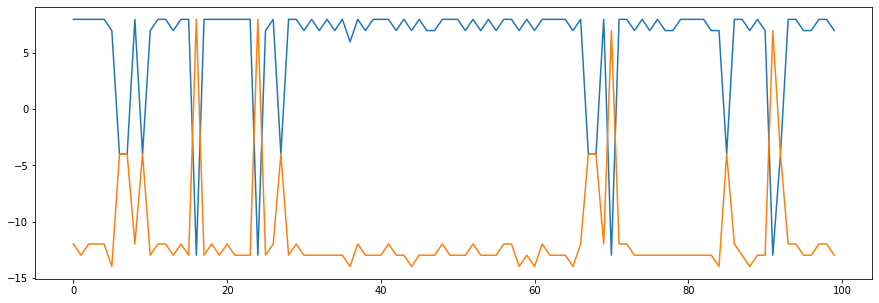

In [25]:
plt.figure(figsize=(15,5))
plt.plot(rew[-100:,])
plt.show()

## Exact Agent

In [29]:
class TicTacToeExactAgent(BaseAgent):
    def agent_init(self, agent_init_info):    
        self.learning_step = agent_init_info["learning_step"]
        self.num_actions = agent_init_info["num_actions"]
        self.rand_generator = np.random.RandomState(agent_init_info["seed"])
        self.states = {}
        self.last_state = None
        self.last_action = None

    def policy(self, q, mask):
        # greedy policy, breaks ties randomly
        pos = np.exp(q - np.max(q)) * mask
        return self.argmax(pos)

    def argmax(self, array):
        m = np.max(array)
        ind = np.where(array == m)[0]
        return self.rand_generator.choice(ind)
    
    def get_q(self, state, mask):
        if str(state) in self.states:
            q = self.states[str(state)]
        else:
            q = np.zeros_like(state)
            q[mask == 1] = 1
        return q
    
    def agent_start(self, state, mask):
        self.last_state = state
        q = self.get_q(state, mask)
        self.states[str(self.last_state)] = q
        self.last_action = self.policy(q, mask)
        return self.last_action        

    def agent_step(self, reward, state, mask):
        # SARSA
        q = self.get_q(state, mask)
        action = self.policy(q, mask)
        q_s_ = q[action]
        q_s = self.states[str(self.last_state)][self.last_action]
        self.states[str(self.last_state)][self.last_action] += self.learning_step * (reward + q_s_ - q_s)

        self.last_state = state
        self.states[str(self.last_state)] = q
        self.last_action = action
        return action
    
    def agent_end(self, reward):
        # SARSA
        q_s = self.states[str(self.last_state)][self.last_action]
        self.states[str(self.last_state)][self.last_action] += self.learning_step * (reward - q_s)
        
    def agent_message(self, message):
        pass

In [31]:
rlglue = RLGlue(TicTacToeEvnironment, TicTacToeExactAgent, DummyAgent)
agent1_info = {"learning_step": 1, "num_actions": 9, "seed": 12}
agent2_info = {"num_actions": 9, "seed": 241}
env_info = {}
rlglue.rl_init(agent1_info, agent2_info, env_info)

In [32]:
# reload states into our exact agent
fr = open('agent-exact-states','rb')
rlglue.agents[-1]["agent"].states = pickle.load(fr)
fr.close()

In [33]:
rlg, rew, starts, states = experiment(rlglue, 10000)

100%|███████████████████████████████████████████████████████████████████████████| 10000/10000 [00:27<00:00, 360.79it/s]


In [34]:
# SARSA agent wins, Dummy agent wins
(rew[:,0] > 0).sum() , (rew[:,1] > 0).sum()

(9187, 0)

We see here that the dummy agent never won a game against the exact agent, and that the exact agent won 9187 times out of 10k. This clearly shows the superiority of the exact agent both against the dummy agent, and against the NN agent.